ThinCurr Python Example: Forces on a ThinCurr model {#doc_tCurr_cyl_forces}
==========
In this example we demonstrate how to compute forces on a model using results of a time-domain simulation for a cylinder.

**Note:** Running this example requires the [h5py](https://www.h5py.org/) and [pyvista](https://pyvista.org/) python packages, which are installable using `pip` or other standard methods.

In [1]:
import struct
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pyvista
pyvista.set_jupyter_backend('static') # Comment to enable interactive PyVista plots
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load ThinCurr library

To load the ThinCurr python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` for binaries on macOS).

In [2]:
thincurr_python_path = os.getenv('OFT_ROOTPATH')
if thincurr_python_path is not None:
    sys.path.append(os.path.join(thincurr_python_path,'python'))
from OpenFUSIONToolkit import OFT_env
from OpenFUSIONToolkit.ThinCurr import ThinCurr
from OpenFUSIONToolkit.ThinCurr.sensor import circular_flux_loop, save_sensors
from OpenFUSIONToolkit.io import histfile

## Setup ThinCurr model
We now create a \ref OpenFUSIONToolkit.OFT_env "OFT_env" instance for execution using two threads and a \ref OpenFUSIONToolkit.ThinCurr.ThinCurr "ThinCurr" instance that utilizes that execution environment.

Once created, we setup the model from an existing HDF5 and XML mesh definition using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.setup_model "setup_model()". For this model we have defined current jumpers using additional nodesets, which must be identified using the `jumper_start` argument (see \ref doc_tCurr_cyl_td-jumpers for more information).

Finally, we initialize I/O for this model using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.setup_io "setup_io()" to enable output of plotting files for 3D visualization in [VisIt](https://visit-dav.github.io/visit-website/index.html), [Paraview](https://www.paraview.org/), or using [pyvista](https://pyvista.org/) below.

In [3]:
myOFT = OFT_env(nthreads=2)
tw_cyl = ThinCurr(myOFT)
tw_cyl.setup_model(mesh_file='thincurr_ex-cyl.h5',xml_filename='oft_in-single.xml',jumper_start=-1)
tw_cyl.setup_io()

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   tCurr_fixes-8_25
Revision id:          d148d6e
Parallelization Info:
  # of MPI tasks      =    1
  # of NUMA nodes     =    1
  # of OpenMP threads =    2
Fortran input file    = /var/folders/52/n5qxh27n4w19qxzqygz2btbw0000gn/T/oft_34324/oftpyin
XML input file        = none
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


Creating thin-wall model
 Orientation depth =         895
  Loading V(t) driver coils
  Loading I(t) driver coils

  # of points    =          795
  # of edges     =         2259
  # of cells     =         1464
  # of holes     =            1
  # of Vcoils    =            0
  # of closures  =            0
  # of Icoils    =            1

  Building holes

  Loading region resistivity:
     1  1.2570E-05


### Compute self-inductance and resistivity matrices
With the model setup, we can now compute the self-inductance and resistivity matrices. A numpy version of the self-inductance matrix will be stored at \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.Lmat "tw_plate.Lmat". By default the resistivity matrix is not moved to python as it is sparse and converting to dense representation would require an increase in memory. These matrices correspond to the $\textrm{L}$ and $\textrm{R}$ matrices for the physical system

$\textrm{L} \frac{\partial I}{\partial t} + \textrm{R} I = V$

**Note:** For larger models calculating the self-inductance may take some time due to the $N^2$ interaction of the elements (see \ref doc_tCurr_hodlr for more information).

In [4]:
Mc = tw_cyl.compute_Mcoil()
tw_cyl.compute_Lmat()
tw_cyl.compute_Rmat()

 Building coil<->element inductance matrices
     Time =  0s          
 Building coil<->coil inductance matrix
 Building element<->element self inductance matrix
     Time =  1s          
 Building resistivity matrix


## Run time-domain simulation
With the model fully defined we can now use \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.run_td "run_td()" to perform a time-domain simulation. In this case we simulate 80 ms using a timestep of 0.2 ms (400 steps). We also specify using a direct solver for the time-advance (`direct=True`) and set the current in the single I-coil defined in the XML input file as a function of time (`coil_currs`), where the first column specifies time points in ascending order and the remaining columns specify coil currents at each time point.

In [5]:
dt = 2.E-4
nsteps = 400
coil_currs = np.array([
    [0.0, 0.0],
    [2.E-2, 10.E3],
    [1.0, 10.E3]
])
tw_cyl.run_td(dt,nsteps,status_freq=10,plot_freq=2,coil_currs=coil_currs,direct=True)


 Starting simulation
 Starting factorization
 Inverting real matrix
   Time =    1.1280000000000000E-002
 Timestep           10   2.00000009E-03   2.23014019E-02           1
 Timestep           20   4.00000019E-03   4.30477262E-02           1
 Timestep           30   6.00000005E-03   6.18482195E-02           1
 Timestep           40   8.00000038E-03   7.88971260E-02           1
 Timestep           50   9.99999978E-03   9.43727940E-02           1
 Timestep           60   1.20000001E-02  0.108436972               1
 Timestep           70   1.40000004E-02  0.121234834               1
 Timestep           80   1.60000008E-02  0.132895797               1
 Timestep           90   1.79999992E-02  0.143534794               1
 Timestep          100   1.99999996E-02  0.152658492               1
 Timestep          110   2.19999999E-02  0.139363602               1
 Timestep          120   2.40000002E-02  0.126853436               1
 Timestep          130   2.60000005E-02  0.115595073              

### Generate plot files
After completing the simulation we can generate plot files using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.plot_td "plot_td()". Plot files are saved at a fixed timestep interval, specified by the `nplot` argument to \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.run_td "run_td()". By default this function only computes currents and sensor/jumper signal. To compute forces we also need the magnetic field, which can be computed by setting the argument `compute_B=True`.

@note For large models, which you intend to run multiple times you may wish to cache the B-field reconstruction operator. To do this you can call the dedicated \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.compute_Bmat "compute_Bmat()" function anytime before calling `plot_td()`

Once all fields have been saved for plotting \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.build_XDMF "build_XDMF()" to generate the XDMF descriptor files for plotting with VisIt of Paraview. This method also returns a \ref OpenFUSIONToolkit.io.XDMF_plot_file "XDMF_plot_file" object, which can be used to read and interact with plot data in Python (see below).

In [6]:
tw_cyl.plot_td(nsteps,compute_B=True)
plot_data = tw_cyl.build_XDMF()

 Post-processing simulation
 Building element->element magnetic reconstruction operator
 Building vcoil->element magnetic reconstruction operator
 Building icoil->element magnetic reconstruction operator
Removing old Xdmf files
  Removed 43 files

Creating output files: oft_xdmf.XXXX.h5
  Found Group: thincurr
    Found Mesh: icoils
      # of blocks: 1
    Found Mesh: smesh
      # of blocks: 1


### Plot current fields using pyvista
For demonstration purposes we now plot the the solution at the end of the driven phase using [pyvista](https://pyvista.org/). We now use the `plot_data` object to generate a 3D plot of the current at `t=2.E-2`. For more information on the basic steps in this block see \ref doc_tCurr_plate_eig

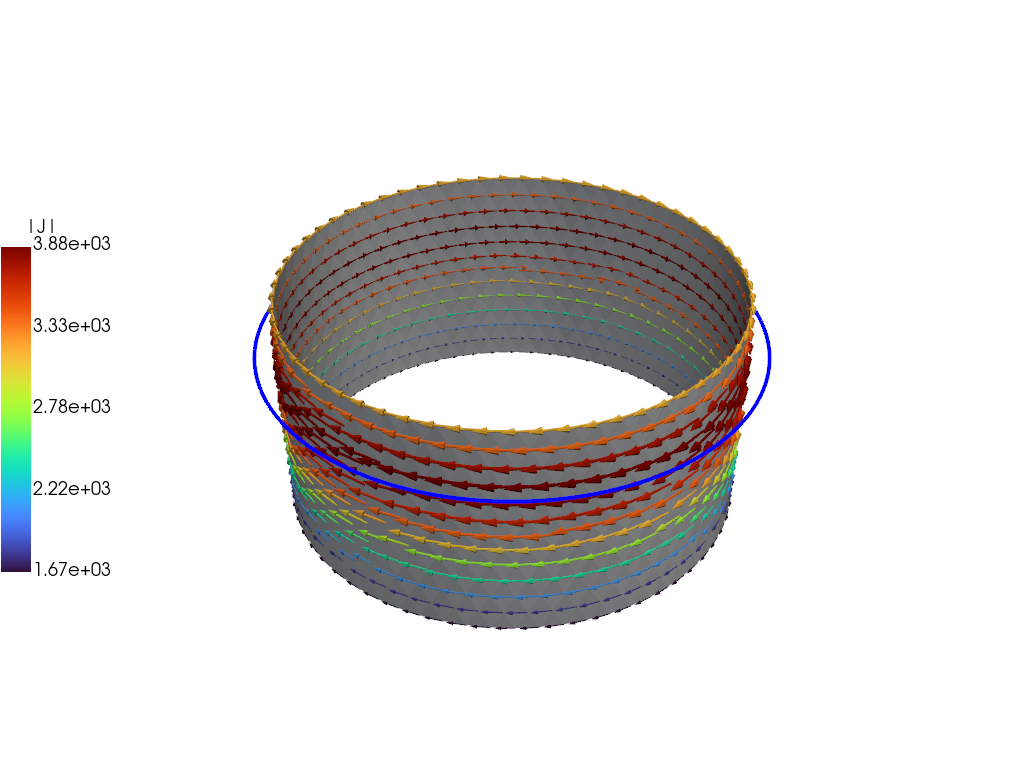

In [7]:
icoil_grid = plot_data['ThinCurr']['icoils'].get_pyvista_grid()
ThinCurr_mesh = plot_data['ThinCurr']['smesh']
grid = ThinCurr_mesh.get_pyvista_grid()
J = ThinCurr_mesh.get_field('J_v',4.E-2)

# Plot mesh and current density using PyVista
p = pyvista.Plotter()
grid["vectors"] = J
grid.set_active_vectors("vectors")
scale = 0.2/(np.linalg.norm(J,axis=1)).max()
arrows = grid.glyph(scale="vectors", orient="vectors", factor=scale)
p.add_mesh(arrows, cmap="turbo", scalar_bar_args={'title': "|J|", "vertical": True, "position_y":0.25, "position_x": 0.0})
p.add_mesh(grid, color="white", opacity=1.0, show_edges=False)
p.add_mesh(icoil_grid, color="blue", opacity=1.0, line_width=4)
p.show()

We can also plot the force distribution on the cylinder using both $J$ and $B$, which gives us the force per unit area over the surface of the cylinder.

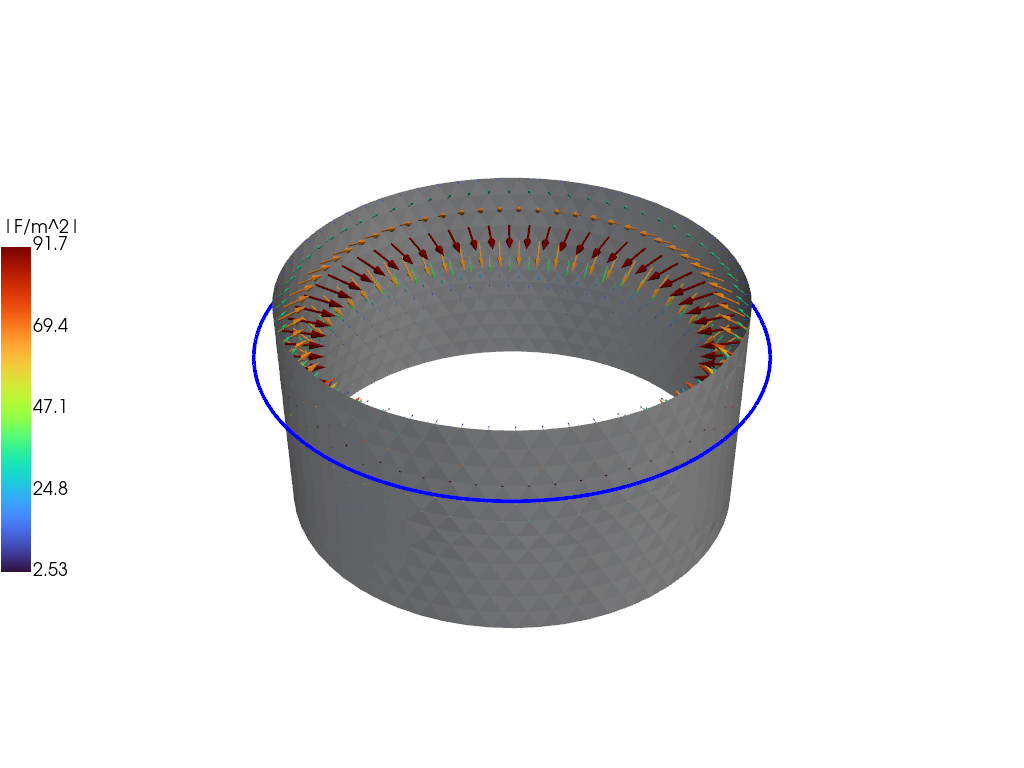

In [8]:
J = ThinCurr_mesh.get_field('J_v',4.E-2)
B = ThinCurr_mesh.get_field('B_v',4.E-2)
P = np.cross(J,B,axis=1)

# Plot mesh and current density using PyVista
p = pyvista.Plotter()
grid["vectors"] = P
grid.set_active_vectors("vectors")
scale = 0.2/(np.linalg.norm(P,axis=1)).max()
arrows = grid.glyph(scale="vectors", orient="vectors", factor=scale)
p.add_mesh(arrows, cmap="turbo", scalar_bar_args={'title': "|F/m^2|", "vertical": True, "position_y":0.25, "position_x": 0.0})
p.add_mesh(grid, color="white", opacity=1.0, show_edges=False)
p.add_mesh(icoil_grid, color="blue", opacity=1.0, line_width=4)
p.show()

## Compute net force on cylinder
We now demonstrate how to get the net force on the cylinder by integrating over the surface. To do this we first need some additional information, including the area of each cell (triangle) and the radial unit vector, which we will use to extract a hoop "force". For ThinCurr's triangular grid these can be readily computed from the information in the plotting mesh.

In [9]:
area = np.zeros((ThinCurr_mesh.nc,))
rhat = np.zeros((ThinCurr_mesh.nc,3))
for i in range(ThinCurr_mesh.nc):
    v1 = ThinCurr_mesh.r[ThinCurr_mesh.lc[i,1],:]-ThinCurr_mesh.r[ThinCurr_mesh.lc[i,0],:]
    v2 = ThinCurr_mesh.r[ThinCurr_mesh.lc[i,2],:]-ThinCurr_mesh.r[ThinCurr_mesh.lc[i,0],:]
    area[i] = np.linalg.norm(np.cross(v1,v2))/2.0
    rcc = (ThinCurr_mesh.r[ThinCurr_mesh.lc[i,2],:]+ThinCurr_mesh.r[ThinCurr_mesh.lc[i,1],:]+ThinCurr_mesh.r[ThinCurr_mesh.lc[i,0],:])/3.0
    rhat[i,:2] = rcc[:2]/np.linalg.norm(rcc[:2])

Then we define a helper function, which computes the desired net force on the cylinder from a cell-centered current density and vertex-centered magnetic field, which we will retrieve from the plot files. The function also supports an optional cell mask, which can be used to restrict the force calculation to specific areas (eg. one region or another in the mesh).

In [10]:
def compute_force(J_cc,B_v,cell_mask=None):
    B_cc = (B_v[ThinCurr_mesh.lc[:,0],:]+B_v[ThinCurr_mesh.lc[:,1],:]+B_v[ThinCurr_mesh.lc[:,2],:])/3.0
    B_cc = B_cc*area[:,None] # Scale by area for faster integration
    if cell_mask is None:
        F_cc = np.cross(J_cc,B_cc,axis=1)
        Fh = np.sum(F_cc*rhat,axis=None)
    else:
        F_cc = np.cross(J_cc[cell_mask,:],B_cc[cell_mask,:],axis=1)
        Fh = np.sum(F_cc*rhat[cell_mask,:],axis=None)
    return np.r_[np.sum(F_cc,axis=0), Fh]

With this information and functionality we can now loop over the desired time points, computing the force at each time. The results show that a significant inward radial force and a downward vertical force, consistent with the physical arrangement of this test where the current in the coil ramps up in time acting to "crush" the cylinder and push it downward due to the vertical offset. Note that the net forces in the azimuthal plane (XY) are zero, so the hoop "force" is not a realy force per-se but instead a representation of the hoop stress that would be present.

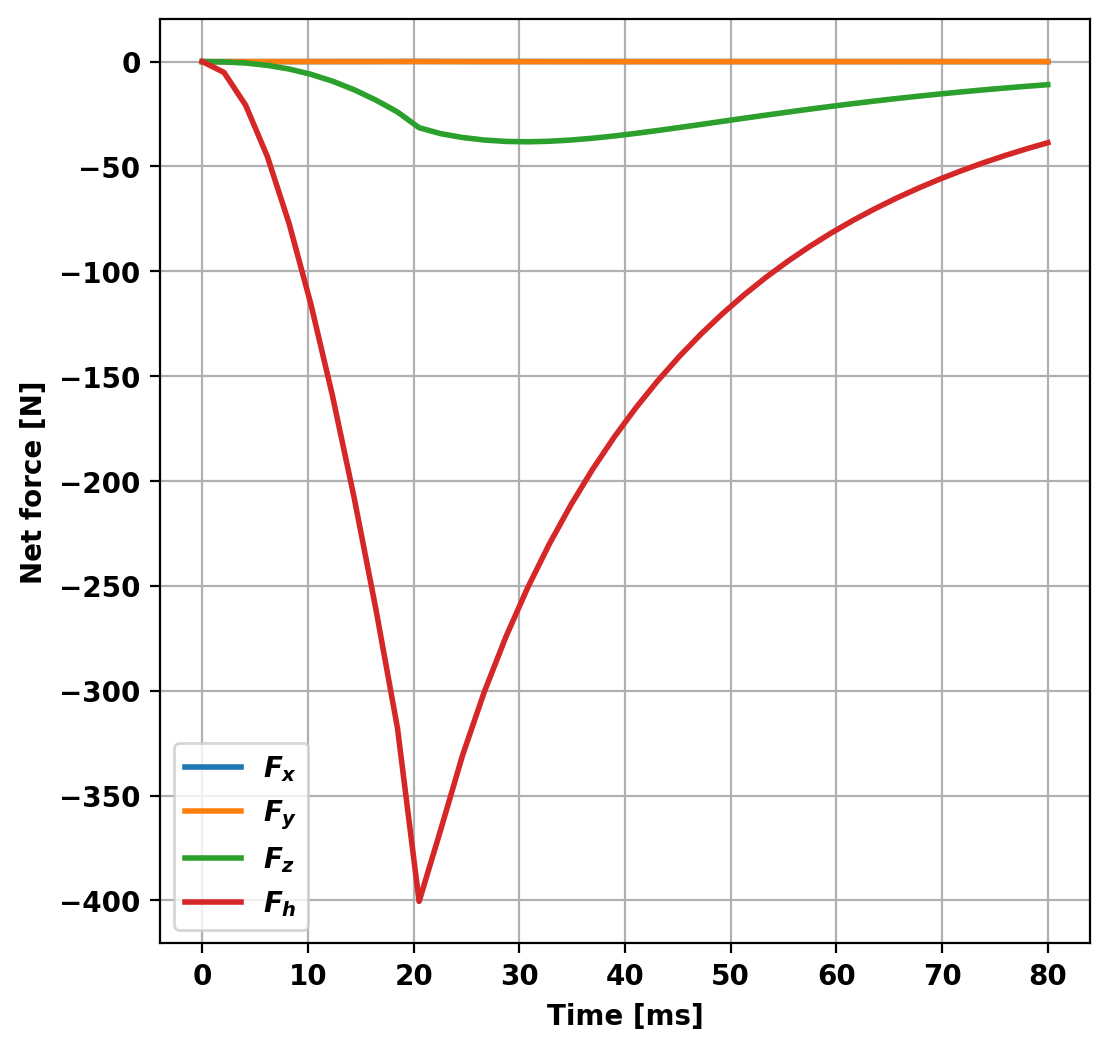

In [11]:
times = np.linspace(0.0,8.E-2,40)
forces = np.zeros((times.shape[0], 4))
for i, time in enumerate(times):
    J_cc = ThinCurr_mesh.get_field('J',time)
    B_v = ThinCurr_mesh.get_field('B_v',time)
    forces[i,:] = compute_force(J_cc,B_v)

# Plot forces
fig, ax = plt.subplots(1,1)
ax.plot(times*1.E3,forces[:,0], label=r'$F_x$')
ax.plot(times*1.E3,forces[:,1], label=r'$F_y$')
ax.plot(times*1.E3,forces[:,2], label=r'$F_z$')
ax.plot(times*1.E3,forces[:,3], label=r'$F_h$')
ax.grid(True)
ax.set_ylabel('Net force [N]')
ax.set_xlabel('Time [ms]')
_ = ax.legend()